In [1]:
%matplotlib inline
from smvjupyter import *                                       # import the UI

usfs_sites = "docs/usfs_sites/Sites_lf_geo.json"               # USFS sites
usfs_regions = "docs/usfs_admin/USFS_Regional_Boundaries.json" # admin regions
usfs_sw = "docs/usfs_admin/southwest_region.json"

app = JupyterSMV(usfs_sites)                 # init UI , anc=usfs_regions, session=session
app.ui                                                         # display UI

In [2]:
layers = app.layers
layers

,id,lat,lon,layer,samples,points,xr
0,0,31.774734,-109.327589,<smvjupyter.Layer object at 0x7ff9ad7360f0>,id lat lon ...,LayerGroup(layers=(CircleMarker(fill_color='bl...,None
1,1,31.505073,-110.536967,<smvjupyter.Layer object at 0x7ff9ad057080>,id lat lon ...,LayerGroup(layers=(CircleMarker(color='#377eb8...,"[SoilSCAPE_surface, SoilSCAPE_rootzone, AirMOS..."
2,2,33.653808,-108.566810,<smvjupyter.Layer object at 0x7ff9ad08a160>,id lat lon ...,LayerGroup(layers=(CircleMarker(fill_color='bl...,None
3,3,35.298089,-111.641646,<smvjupyter.Layer object at 0x7ff9acfef518>,id lat lon ...,LayerGroup(layers=(CircleMarker(fill_color='bl...,None
4,4,33.996685,-108.673179,<smvjupyter.Layer object at 0x7ff9acfefd68>,id lat lon ...,LayerGroup(layers=(CircleMarker(fill_color='bl...,None
5,5,34.020165,-109.401942,<smvjupyter.Layer object at 0x7ff9ab729748>,id lat lon ...,LayerGroup(layers=(CircleMarker(fill_color='bl...,None
6,6,47.606681,-103.517068,<smvjupyter.Layer object at 0x7ff9ab73a6d8>,id lat lon ...,LayerGroup(layers=(CircleMarker(fill_color='bl...,None
7,7,46.752166,-103.556410,<smvjupyter.Layer object at 0x7ff9ab706630>,id lat lon ...,LayerGroup(layers=(CircleMarker(fill_color='bl...,None
8,8,37.714688,-106.863892,<smvjupyter.Layer object at 0x7ff9ad047fd0>,id lat lon ...,LayerGroup(layers=(CircleMarker(fill_color='bl...,None
9,9,37.337869,-103.076888,<smvjupyter.Layer object at 0x7ff9ab5ed5c0>,id lat lon ...,LayerGroup(layers=(CircleMarker(fill_color='bl...,None


In [4]:
layer = layers.iloc[1]
layer

id                                                         1
lat                                                  31.5051
lon                                                 -110.537
layer            <smvjupyter.Layer object at 0x7ff9ad057080>
samples        id        lat         lon                 ...
points     LayerGroup(layers=(CircleMarker(color='#377eb8...
xr         [SoilSCAPE_surface, SoilSCAPE_rootzone, AirMOS...
Name: 1, dtype: object

In [71]:
xrds = layer.xr
xrds_mean = xrds.sel(stat="Mean", drop=True).mean("sample", keep_attrs=True)
xrds_mean

<xarray.Dataset>
Dimensions:                     (time: 6179)
Coordinates:
  * time                        (time) datetime64[ns] 2002-04-01 ... 2019-03-01
Data variables:
    SoilSCAPE_surface           (time) float64 nan nan nan nan ... nan nan nan
    SoilSCAPE_rootzone          (time) float64 nan nan nan nan ... nan nan nan
    AirMOSS_L2_3_surface        (time) float64 nan nan nan nan ... nan nan nan
    AirMOSS_L2_3_rootzone       (time) float64 nan nan nan nan ... nan nan nan
    AirMOSS_L4_rootzone         (time) float64 nan nan nan nan ... nan nan nan
    SMAP_surface                (time) float64 nan nan nan ... 17.43 19.38 17.43
    SMAP_rootzone               (time) float64 nan nan nan ... 20.81 20.92 20.77
    NEE_mean                    (time) float64 nan nan nan nan ... nan nan nan
    GPP_mean                    (time) float64 nan nan nan nan ... nan nan nan
    prcp                        (time) float64 nan nan nan nan ... nan nan nan
    tmax                        (ti

## plotting config

In [135]:
plt.rc("font", **{"family": "normal", "weight": "bold", "size": 12})
plt.rc("axes", **{"xmargin": 0.01})

In [209]:
prcp.index

DatetimeIndex(['2002-04-30', '2002-05-31', '2002-06-30', '2002-07-31',
               '2002-08-31', '2002-09-30', '2002-10-31', '2002-11-30',
               '2002-12-31', '2003-01-31',
               ...
               '2018-06-30', '2018-07-31', '2018-08-31', '2018-09-30',
               '2018-10-31', '2018-11-30', '2018-12-31', '2019-01-31',
               '2019-02-28', '2019-03-31'],
              dtype='datetime64[ns]', name='time', length=204, freq='M')

## plot Daymet

Text(0, 0.5, 'mm/day')

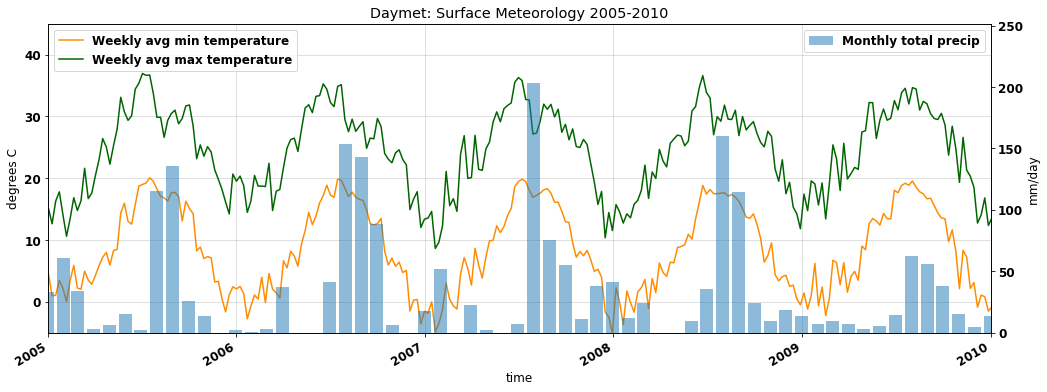

In [243]:
fig, ax0 = plt.subplots(figsize=(14,5))
fig.tight_layout()
ax1 = ax0.twinx()

daymet = xrds_mean.filter_by_attrs(source="Daymet")
prcp = daymet.prcp.resample(time="1m", keep_attrs=True).sum(keep_attrs=True).to_series() # sum precip over 1month
tmin = daymet.tmin.resample(time="1w", keep_attrs=True).mean(keep_attrs=True)            # avg tmin over 1week
tmax = daymet.tmax.resample(time="1w", keep_attrs=True).mean(keep_attrs=True)            # avg tmax over 1week

l1 = tmin.plot(ax=ax0, color="darkorange", label="Weekly avg min temperature")
l2 = tmax.plot(ax=ax0, color="darkgreen", label="Weekly avg max temperature")
ax1.bar(prcp.index, prcp, width=25, alpha=0.5, label="Monthly total precip")

ax0.set_ylim(-5, 45)
ax0.set_xlim("2005", "2010")
ax0.grid("on", alpha=0.5)
ax0.legend(loc="upper left")
ax0.set_ylabel(tmin.attrs["units"])
ax0.set_title("Daymet: Surface Meteorology 2005-2010")

ax1.legend()
ax1.set_ylabel(daymet.prcp.attrs["units"])

## plot soil moisture

#### from SMAP

Text(0, 0.5, 'g m-2 d-1')

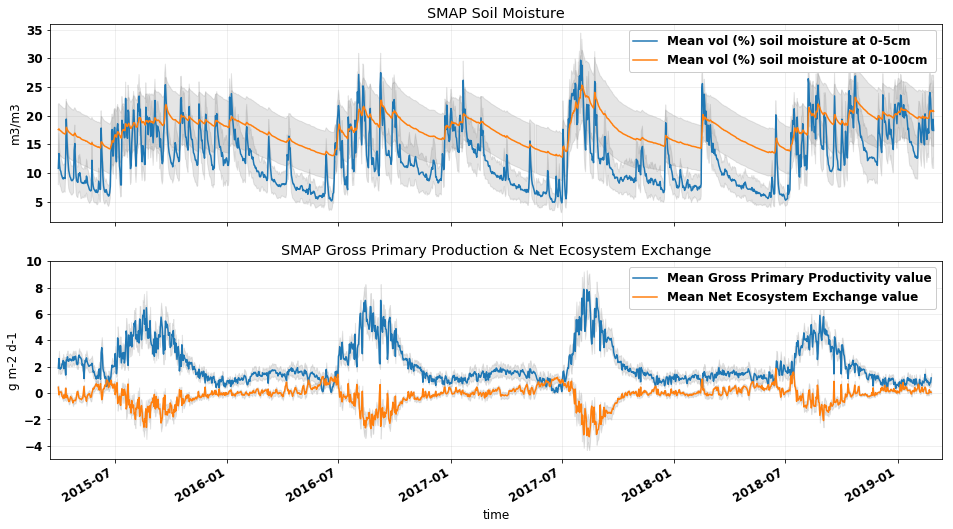

In [157]:
smap = xrds.filter_by_attrs(source="SMAP").sel(stat="Mean", drop=True)

fig, axs = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(16, 8))

for p in [("SMAP_surface", 0), ("SMAP_rootzone", 0), ("GPP_mean", 1), ("NEE_mean", 1)]:
    ax = axs[p[1]]
    data = smap[p[0]]
    desc = data.attrs["description"]

    ptime = data.time.data
    pmean = data.mean("sample", keep_attrs=True)
    pstd = data.std("sample", keep_attrs=True)
    pmean.plot.line(x="time", ax=ax, label=desc, add_legend=False)
    ax.fill_between(ptime, (pmean-pstd), (pmean+pstd), color="gray", alpha=0.2)
    
axs[0].set_xlabel(None) 
axs[0].set_title("SMAP Soil Moisture")
axs[1].set_title("SMAP Gross Primary Production & Net Ecosystem Exchange")
axs[0].grid('on', alpha=0.25); axs[1].grid('on', alpha=0.25)
axs[0].legend(loc=0, framealpha=1); axs[1].legend(loc=0, framealpha=1)
axs[0].set_ylabel("m3/m3"); axs[1].set_ylabel("g m-2 d-1")

#### from AirMOSS

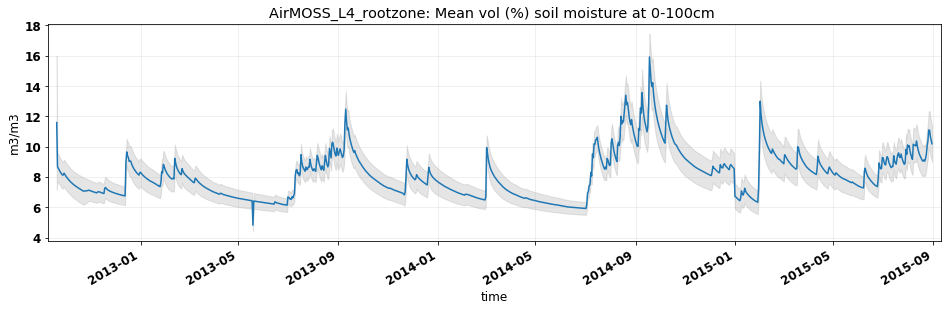

In [158]:
airmoss = xrds.filter_by_attrs(source="AirMOSS").sel(stat="Mean", drop=True)

data = airmoss["AirMOSS_L4_rootzone"]
ptime = data.time.data
pmean = data.mean("sample", keep_attrs=True)
pstd = data.std("sample", keep_attrs=True)

fig = plt.figure(figsize=(16, 4))
ax = plt.gca()
pmean.plot.line(x="time", ax=ax, label=desc, add_legend=False)
ax.fill_between(ptime, (pmean-pstd), (pmean+pstd), color="gray", alpha=0.2)
ax.set_title("AirMOSS_L4_rootzone: "+data.attrs["description"])
ax.set_ylabel(data.attrs["units"])
ax.grid("on", alpha=0.25)

##### in case there is data from more than one airmoss dataset:

In [ ]:
airmoss = xrdataset.filter_by_attrs(source="AirMOSS").sel(stat="Mean", drop=True)

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(16, 4))

for name, dataset in airmoss.items(): 
    ax = axs[0] if dataset.attrs["type"]=="airborne" else axs[1]
    desc = dataset.attrs["description"]
    pmean = dataset.mean("sample", keep_attrs=True)
    if not all(pmean.isnull()):
        pmean.plot.line(x="time", ax=ax, label=desc, add_legend=False)

    ax.set_title(None)
    ax.grid("on", alpha=0.25)

### all soil moisture datasets

In [248]:
rootzone = xrds.filter_by_attrs(type="in situ", soil_zone="rootzone").sel(stat="Mean", drop=True)
surface = xrds.filter_by_attrs(type="in situ", soil_zone="surface").sel(stat="Mean", drop=True)
rootzone

<xarray.Dataset>
Dimensions:                     (sample: 18, time: 6179)
Coordinates:
  * time                        (time) datetime64[ns] 2002-04-01 ... 2019-03-01
  * sample                      (sample) int64 0 1 2 3 4 5 ... 12 13 14 15 16 17
    lon                         (sample) float64 -110.4 -110.4 ... -110.4 -110.3
    lat                         (sample) float64 31.83 31.75 ... 31.34 31.34
Data variables:
    SoilSCAPE_rootzone          (sample, time) float64 nan nan nan ... nan nan
    AirMOSS_in-ground_rootzone  (sample, time) float64 nan nan nan ... nan nan
    COSMOS_rootzone             (sample, time) float64 nan nan nan ... nan nan
    CRN_rootzone                (sample, time) float64 nan nan nan ... nan nan
    SCAN_rootzone               (sample, time) float64 nan nan nan ... nan nan
    SNOTEL_rootzone             (sample, time) float64 nan nan nan ... nan nan

Text(0.5, 1.0, 'Rootzone soil moisture from in situ sources')

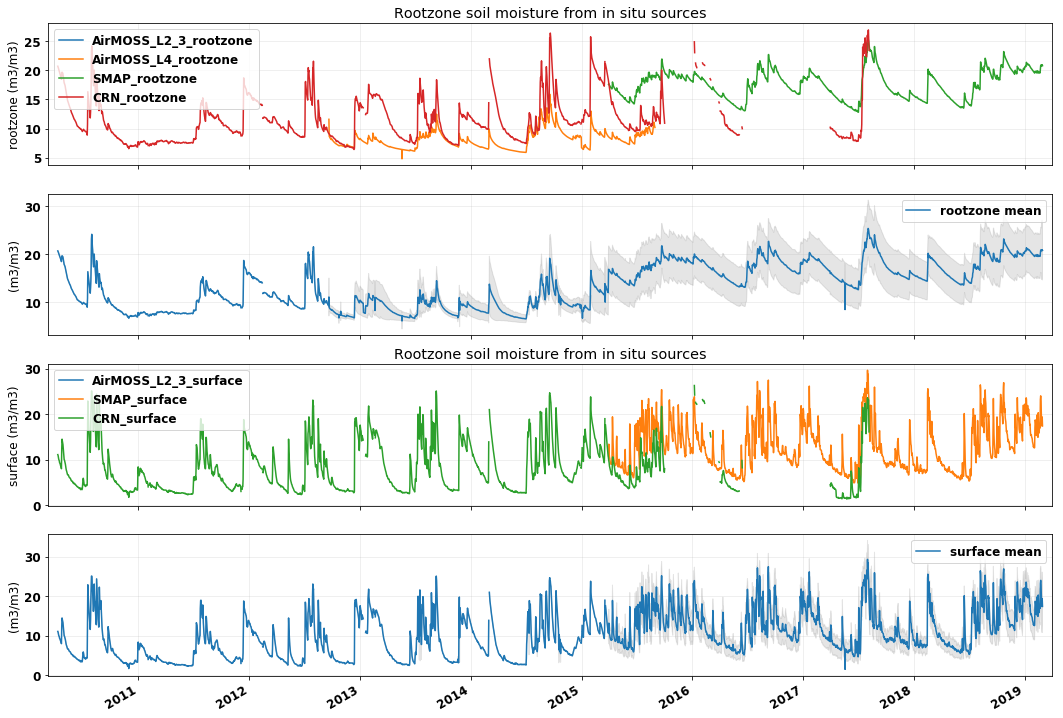

In [313]:
fig, axs = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(18, 12))

soil_moisture = xrds.filter_by_attrs(units="m3/m3").sel(stat="Mean", drop=True)
rootzone = soil_moisture.filter_by_attrs(soil_zone="rootzone")
surface = soil_moisture.filter_by_attrs(soil_zone="surface")

for plotter in [(0, "rootzone", rootzone), (2, "surface", surface)]:
    axa, axb = axs[plotter[0]], axs[plotter[0]+1]
    
    arrays = []
    for name, dataset in plotter[2].items():
        data = dataset.mean("sample") if "sample" in dataset.dims else dataset
        if not all(data.isnull()):
            data.plot.line(ax=axa, x="time", label=name, add_legend=False)
            arrays.append(dataset)

    stack = xr.concat(arrays, "mean").stack(cat=("mean", "sample"))
    pmean, pstd = stack.mean("cat"), stack.std("cat")
    pmean.plot(x="time", ax=axb, label=plotter[1]+" mean")
    axb.fill_between(pmean.time.data, (pmean-pstd), (pmean+pstd), color="gray", alpha=0.2)
    
    axa.set_ylabel(plotter[1]+" (m3/m3)"); axb.set_ylabel("(m3/m3)")
    axa.grid("on", alpha=0.25); axb.grid("on", alpha=0.25); 
    axa.legend(loc=2); axb.legend(loc=1)
    axa.set_xlabel(None); axb.set_xlabel(None)


axs[0].set_title("Rootzone soil moisture from in situ sources")
axs[2].set_title("Surface soil moisture from in situ sources")

In [ ]:
for i, p in enumerate(["AirMOSS_L2_3_surface", "AirMOSS_L2_3_rootzone", "AirMOSS_L4_rootzone"]):
    ax = axs[i]
    data = airmoss[p]
    desc = data.attrs["description"]

    ptime = data.time.data
    pmean = data.mean("sample", keep_attrs=True)
    pstd = data.std("sample", keep_attrs=True)
    pmean.plot.line(x="time", ax=ax, label=desc, add_legend=False)
    ax.fill_between(ptime, (pmean-pstd), (pmean+pstd), color="gray", alpha=0.2)
    
    ax.set_title(None)
    ax.grid("on", alpha=0.25)

In [ ]:
airmoss = xrds.filter_by_attrs(source="AirMOSS").sel(stat="Mean", drop=True)

fig, axs = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(15, 8))
plt.subplots_adjust(hspace=0.000)

for i, p in enumerate(["AirMOSS_L2_3_surface", "AirMOSS_L2_3_rootzone", "AirMOSS_L4_rootzone"]):
    ax = axs[i]
    data = airmoss[p]
    desc = data.attrs["description"]

    ptime = data.time.data
    pmean = data.mean("sample", keep_attrs=True)
    pstd = data.std("sample", keep_attrs=True)
    pmean.plot.line(x="time", ax=ax, label=desc, add_legend=False)
    ax.fill_between(ptime, (pmean-pstd), (pmean+pstd), color="gray", alpha=0.2)
    
    ax.set_title(None)
    ax.grid("on", alpha=0.25)

In [ ]:
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(15,10))
ax1, ax2, ax3 = axs
ax4 = ax3.twinx()

In [ ]:
fig, ax0 = plt.subplots(figsize=(14,5))
fig.tight_layout()
ax1 = ax0.twinx()

daymet = xrds_mean.filter_by_attrs(source="Daymet")
prcp = daymet.prcp.resample(time="1m", keep_attrs=True).sum(keep_attrs=True)
l1 = daymet.tmin.plot(ax=ax0, color="darkgreen")
l2 = daymet.tmax.plot(ax=ax0, color="darkorange")
l3 = prcp.plot(ax=ax1, marker="o")

labels = ["Daily min temperature (deg C)", 
          "Daily max temperature (deg C)", 
          "Monthly total precip (mm/day)"]
ax1.legend(l1+l2+l3, labels, loc="upper right", framealpha=0.75)

ax0.grid("on", alpha=0.25)
ax0.set_ylabel(daymet.tmin.attrs["units"])
ax0.set_title("Daymet: surface meteorology")
ax1.set_ylabel(prcp.attrs["units"])
ax1.set_title(None)

# batch download big area

In [ ]:
urls = []

s = app.layers.samples.item()
for i, r in s.iterrows():
    urls.append(r.samp.dl)

print(len(urls))

In [ ]:
def get_sample_xr(df, id, lat, lon):
    """ """

    d = ["sample"]                          
    s = xr.DataArray(data=[id], dims=d) # get sample, lat, lon xr arrays
    y = xr.DataArray(data=[lat], coords=[s], dims=d, attrs=latatts)
    x = xr.DataArray(data=[lon], coords=[s], dims=d, attrs=lonatts)

    ds = {}
    for dataset in df.columns:
        a = smvdatasets.loc[dataset].to_dict()
        if a["source"] not in disabled_sources:
            split_column = split_pd(df[dataset])
            ds[dataset] = pd_to_xr(dataset, split_column)

    xds = xr.merge(ds.values())                          # merge to one xr
    xds = xds.assign_coords(lat=y, lon=x)                # add coord arrays
    
    return(xds)


outdir = "/home/jack/tmp/"
for i, u in enumerate(urls):
    print("Processing "+str(i))
    
    lat, lon = [float(c.split("&")[0]) for c in u.split("=")[1:3]]
    out = outdir+str(i)+"_"+str(lat)+"_"+str(lon)+"."
    
    response = requests.get(u, cookies=auth)
    rtxt = response.text
    with open(out +"txt", "w") as f:
        f.write(rtxt)
    df = txt_to_pd(rtxt)                       # read to df
    xrds = get_sample_xr(df, i, lat, lon)                # get xr dataset
    
    comp = dict(zlib=True, complevel=5)
    encoding = {var: comp for var in xrds.data_vars}
    xrds.to_netcdf(out +"nc", encoding=encoding)